<a href="https://colab.research.google.com/github/leeeeeyeon/ICE4101-HW2/blob/main/HW2_base_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2

*   Submit result analysis report (within 6 pages, at least 3 pages, pdf format)
*   **Analysis of experimental results by modifying hyperparameters**
(e.g. epoch, learning rate, optimizer, activation function ..)
*   **Analysis and discussion through various experiments** is more important than improving performance
*   Active use of tables and graphs
*   If necessary, attach a link to your colab code
*   Code is based on ResNet-50








# 1.Install TensorFlow 2.1.0

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0

Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0+zzzcolab20220506162203.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? 
Your response ('') was not one of the expected responses: y, n
Proceed (y/n)? y

  Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 57.3 MB/s 
     |████████████████████████████████| 50 kB 9.

# 2.Runtime restart

**런타임 -> 런타임 다시 시작 -> 다음 코드 진행**

# 3.Prepare dataset

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

#print(tfds.list_builders())
dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBBM1T2/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBBM1T2/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashio

In [ ]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128 # >>>>>>>>>>>>> hyperparameters <<<<<<<<<<<<<<<<<<

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

# 4.Data Agumentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator()
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)


# 5.Define model

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()
        
        channel = channel_out // 4
        
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)
        
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y
    
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)
        
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
           
class ResNet50(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()                
        
        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)                
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)                
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)                
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
        
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)    
            else:
                x = layer(x)
        return x
       
    
model = ResNet50((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 75904     
 ck)                                                             
                                                         

In [ ]:
# >>>>>>>>>>>>> hyperparameters <<<<<<<<<<<<<<<<<<

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay =  0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


# 6.Prepare training

In [ ]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')


In [ ]:
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(label, predictions)
        
@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)
    
    test_loss(loss)
    test_accuracy(label, predictions)

# 7.Train

In [ ]:
import time

num_epoch = 30 # >>>>>>>>>>>>> hyperparameters <<<<<<<<<<<<<<<<<<
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):    
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break
        
    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)
        
    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())    
    
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Loss: 0.9830142259597778, Accuracy: 61.961669921875, Test Loss: 0.6192893981933594, Test Accuracy: 76.66000366210938, spent_time: 1.6660054206848145 min
Epoch 2, Loss: 0.7610956430435181, Accuracy: 70.82250213623047, Test Loss: 0.5442621111869812, Test Accuracy: 79.49500274658203, spent_time: 2.960526692867279 min
Epoch 3, Loss: 0.6628636121749878, Accuracy: 74.68555450439453, Test Loss: 0.5221478343009949, Test Accuracy: 80.50666809082031, spent_time: 4.249193807442983 min
Epoch 4, Loss: 0.6038997769355774, Accuracy: 76.97332763671875, Test Loss: 0.5104180574417114, Test Accuracy: 80.93000030517578, spent_time: 5.551902000109354 min
Epoch 5, Loss: 0.5622178912162781, Accuracy: 78.5893325805664, Test Loss: 0.4784402847290039, Test Accuracy: 82.19200134277344, spent_time: 6.831467894713084 min
Epoch 6, Loss: 0.5303201675415039, Accuracy: 79.82194519042969, Test Loss: 0.457363098859787, Test Accuracy: 82.97332763671875, spent_time: 8.117404540379843 min
Epoch 7, Loss: 0.50481122

# 8.Show transition of accuracy

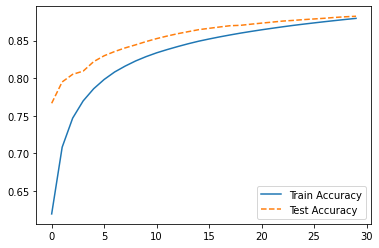

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()                                                                                                                  